In [2]:
# note - I use DYCORSStrategy instead of SOP because Im just using one processor and not multiple and 
# the test problems are not of an extremely high dimensionality
import logging
import os.path

import numpy as np
from poap.controller import BasicWorkerThread, ThreadController

from pySOT.auxiliary_problems import candidate_uniform
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.experimental_design import LatinHypercube
from pySOT.surrogate import RBFInterpolant, CubicKernel, LinearTail
from pySOT.strategy import SRBFStrategy
from pySOT.optimization_problems import SixHumpCamel
from pySOT.utils import unit_rescale
from pySOT.strategy import DYCORSStrategy
from pySOT.utils import progress_plot
from poap.controller import ThreadController, SerialController, BasicWorkerThread
import scipy.spatial as scpspatial
import scipy
from scipy.integrate import quad
import random

import matplotlib.pylab as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [20]:
class Lm_SixHumpCamel(SixHumpCamel):
    """Six-hump camel function

    Details: https://www.sfu.ca/~ssurjano/camel6.html

    Global optimum: :math:`f(0.0898,-0.7126)=-1.0316`

    :ivar dim: Number of dimensions
    :ivar lb: Lower variable bounds
    :ivar ub: Upper variable bounds
    :ivar int_var: Integer variables
    :ivar cont_var: Continuous variables
    :ivar min: Global minimum value
    :ivar minimum: Global minimizer
    :ivar info: String with problem info
    """

    def __init__(self,ep = 1):
        self.ep = ep
        self.dim = 2
        #self.c = self.eval(np.random.random(size = 2))
        self.c = 0
        self.H_ys = []
        self.beta = 1/ep
        self.min = -1.0316
        self.minimum = np.array([0.0898, -0.7126])
        self.lb = -3.0 * np.ones(2)
        self.ub = 3.0 * np.ones(2)
        self.int_var = np.array([])
        self.cont_var = np.arange(0, 2)
        self.info = "2-dimensional Six-hump function \nGlobal optimum: " + "f(0.0898, -0.7126) = -1.0316"

            # linear f
    def eval1(self, x):
        """Evaluate the modified SixHumpCamel function  at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.log((H_y - self.c + self.ep)/self.ep)
        else:
            return (
                scipy.integrate.quad(lambda u: 1/(u - self.c + self.ep), a = self.min, b = H_y)[0]
            )
    
    # quadratic f
    def eval2(self, x):
        """Evaluate the modified SixHumpCamel function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.sqrt(self.beta)*np.arctan(np.sqrt(self.beta)*(H_y - self.c))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**2 + self.ep), a = self.min, b = H_y)[0]
            )
    
    # square root f
    def eval3(self, x):
        """Evaluate the modified SixHumpCamel function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return (self.beta*(self.c - self.min) + 2*np.sqrt(H_y - self.c)
                    - 2*self.ep*np.log((np.sqrt(H_y - self.c) + self.ep)/self.ep))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**(1/2) + self.ep), a = self.min, b = H_y)[0]
            )


In [4]:
def ex_helper(times):
    max_evals = 100
    l2 = np.zeros((max_evals,times))
    for i in range(times):
        np.random.seed(i)
        random.seed(i)
        lm_sixhumpcamel = Lm_SixHumpCamel()
        rbf = RBFInterpolant(dim=lm_sixhumpcamel.dim, lb=lm_sixhumpcamel.lb, ub=lm_sixhumpcamel.ub, kernel=CubicKernel(), tail=LinearTail(lm_sixhumpcamel.dim))
        slhd = SymmetricLatinHypercube(dim=lm_sixhumpcamel.dim, num_pts=2 * (lm_sixhumpcamel.dim + 1))
        controller1 = SerialController(objective=lm_sixhumpcamel.eval)
        controller1.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_sixhumpcamel, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )
        # Run the optimization strategy
        result1 = controller1.run()
        l2[:,i] = np.array(
                [o.value for o in controller1.fevals if o.value is not None])
    return l2

In [5]:
l2 = ex_helper(30)

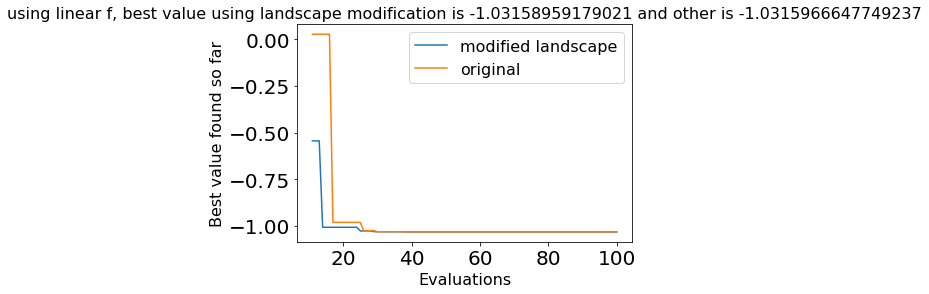

(-1.03158959179021, -1.0315966647749237)

In [22]:
%matplotlib inline
path = '/Users/venkatkrishnakarumanchi/Desktop/paper_results/6_hump_camel_results/quadratic/zero_c'

    
def example_simple(state,path,i,l2):
    np.random.seed(state)
    random.seed(state)
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    max_evals = 100
    
    lm_sixhumpcamel = Lm_SixHumpCamel()
    rbf = RBFInterpolant(dim=lm_sixhumpcamel.dim, lb=lm_sixhumpcamel.lb, ub=lm_sixhumpcamel.ub, kernel=CubicKernel(), tail=LinearTail(lm_sixhumpcamel.dim))
    slhd = SymmetricLatinHypercube(dim=lm_sixhumpcamel.dim, num_pts=2 * (lm_sixhumpcamel.dim + 1))

    # Create a strategy and a controller
    # can change landscape by changing eval1 to eval2 or eval3 based on preferance
    controller = SerialController(objective=lm_sixhumpcamel.eval2)
    controller.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_sixhumpcamel, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )
    # Run the optimization strategy
    while True:
        try:
            result = controller.run()
            break
        except AssertionError:
            print('minimum was found')

    l1 = lm_sixhumpcamel.H_ys
    
    fvals1 = np.minimum.accumulate(l1)
    fvals2 = np.minimum.accumulate(l2[:,i])
    for results in [fvals1[10:],fvals2[10:]]:
        plt.errorbar(np.arange(start = 10, stop = 100)+1, y=results)

    plt.ylabel("Best value found so far", fontsize=16)
    plt.xlabel("Evaluations", fontsize=16)
    plt.legend(("modified landscape", "original"), fontsize=16)
    plt.title('using linear f, best value using landscape modification is {0} and other is {1}'.
              format(lm_sixhumpcamel.eval(result.params[0]),min(l2[:,i])),
              fontsize = 16)
    #plt.figure(facecolor=(1, 1, 1))
    plt.savefig(path + '/graph_iter_{0}.jpg'.format(i), dpi = 200)
    plt.show()

    
    return lm_sixhumpcamel.eval(result.params[0]),min(l2[:,i])
    

example_simple(13,path,13,l2)

In [23]:
def rmse(x,x1):
    return np.sqrt(np.mean((x - x1)**2))

def checker(times,path,l2):
    lm = 0
    lm_list = []
    no_lm = 0
    no_lm_list = []
    for i in range(times):
        res = example_simple(i,path,i,l2)
        lm_list.append(res[0])
        no_lm_list.append(res[1])
        if res[0] < res[1]:
            lm += 1
        else:
            no_lm += 1
    print('landscape modified was better {0} times and was worse {1} times'.format(lm,no_lm))
    print('mean of landscape modified is {}'.format(np.mean(lm_list)))
    print('mean of non landscape modified is {}'.format(np.mean(no_lm_list)))
    print('median of landscape modified is {}'.format(np.median(lm_list)))
    print('median of non landscape modified is {}'.format(np.median(no_lm_list)))
    print('standard_deviation of landscape modified is {}'.format(np.std(lm_list)))
    print('standard_deviation of non landscape modified is {}'.format(np.std(no_lm_list)))
    print('best result of landscape modified is {}'.format(np.min(lm_list)))
    print('best of non landscape modified is {}'.format(np.min(no_lm_list)))
    print('worst result of landscape modified is {}'.format(np.max(lm_list)))
    print('worst of non landscape modified is {}'.format(np.max(no_lm_list)))
    return lm_list,no_lm_list
    

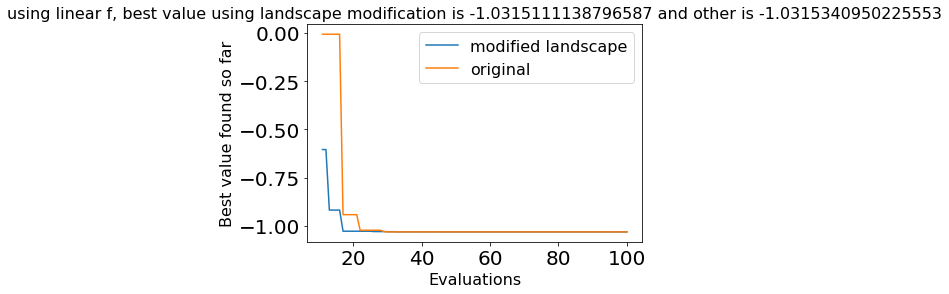

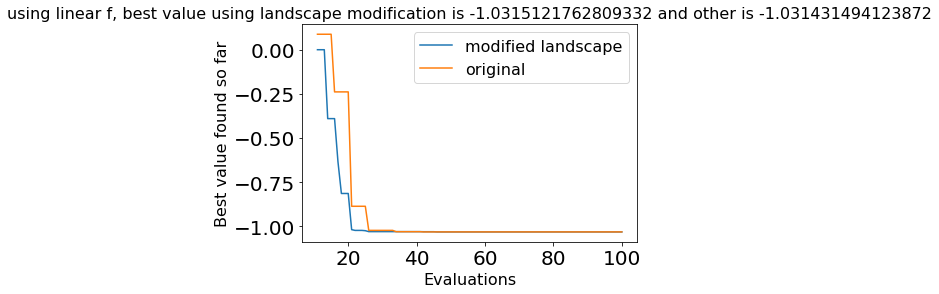

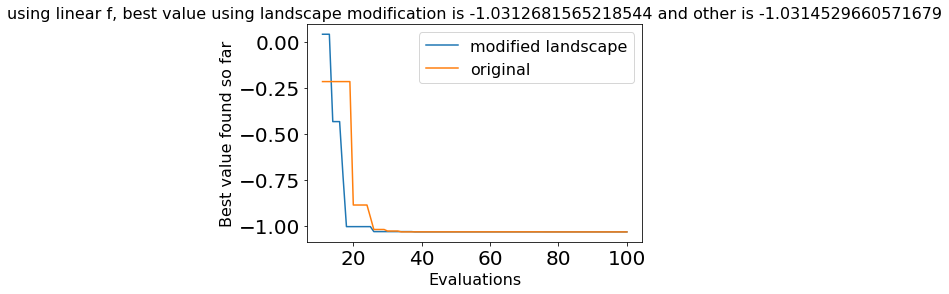

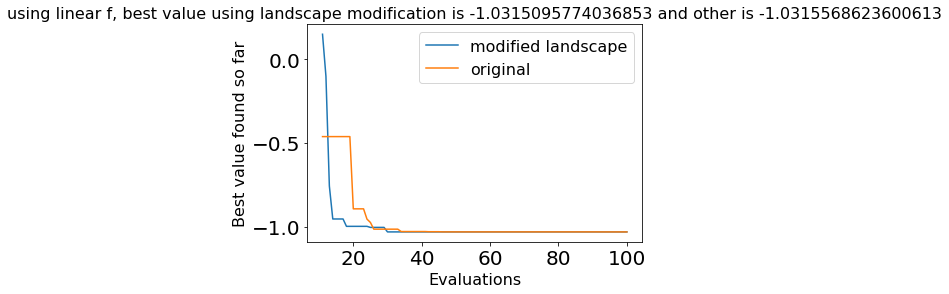

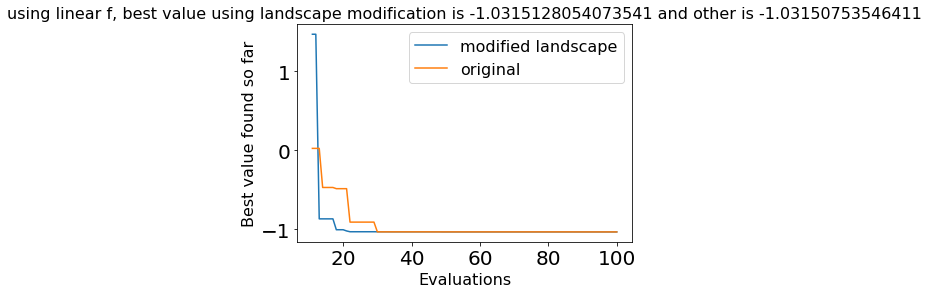

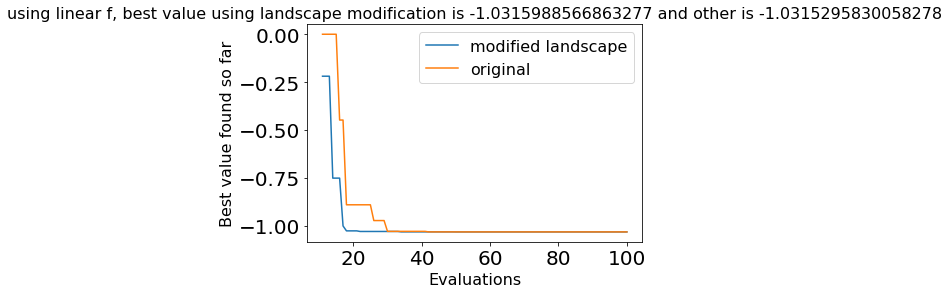

minimum was found


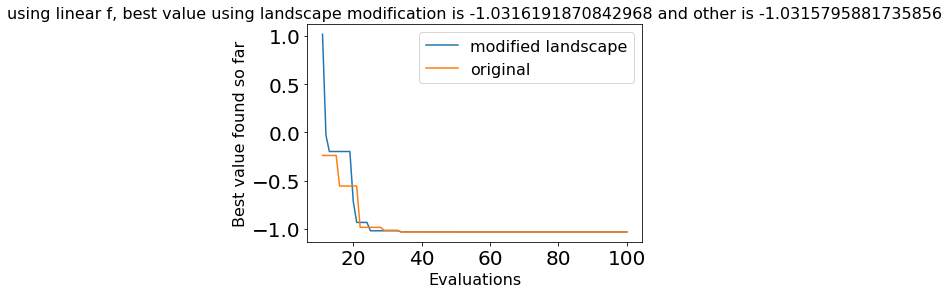

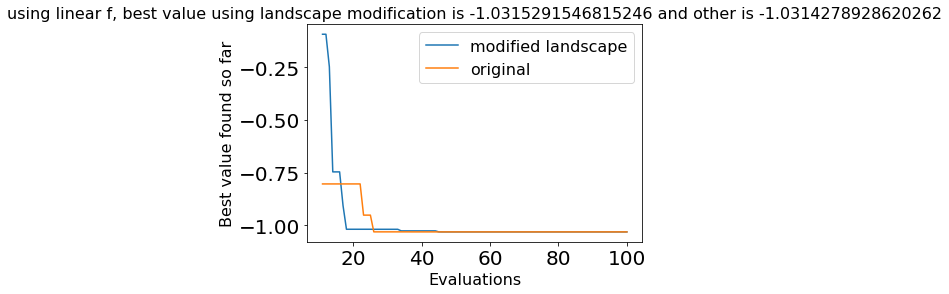

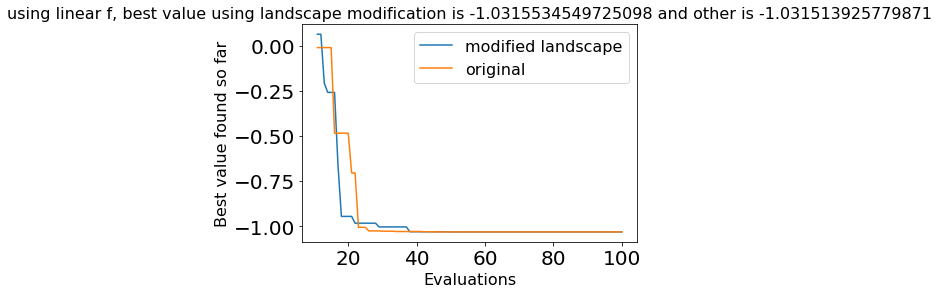

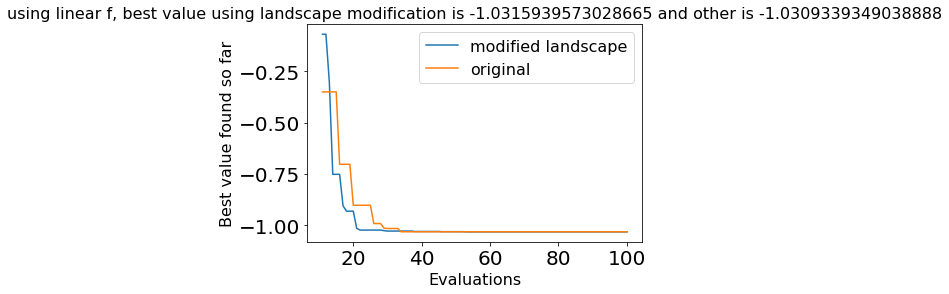

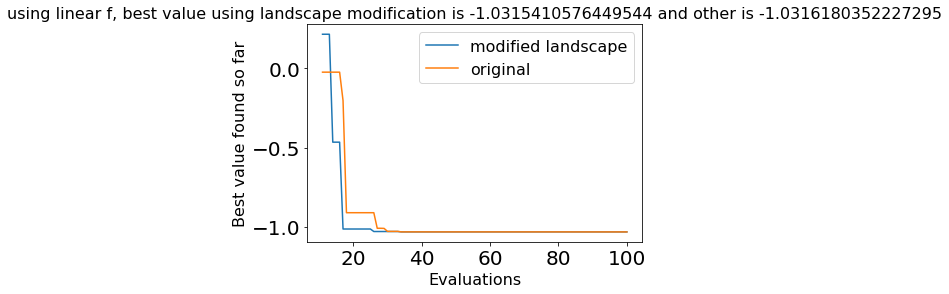

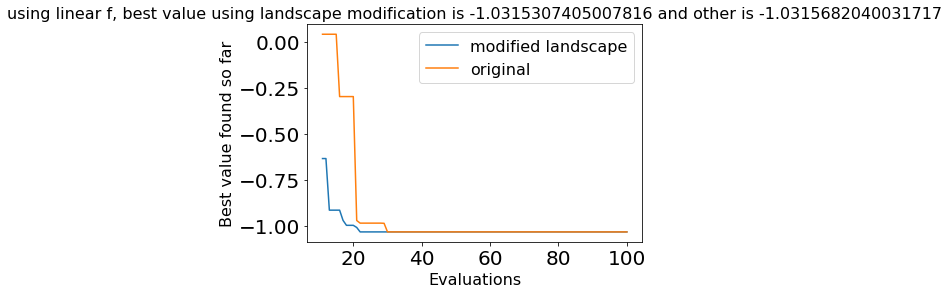

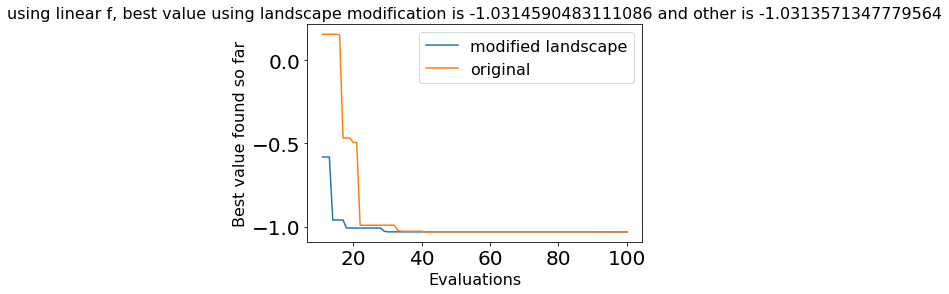

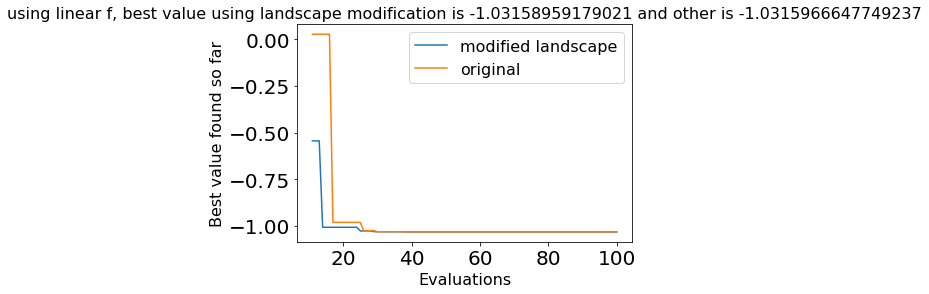

minimum was found


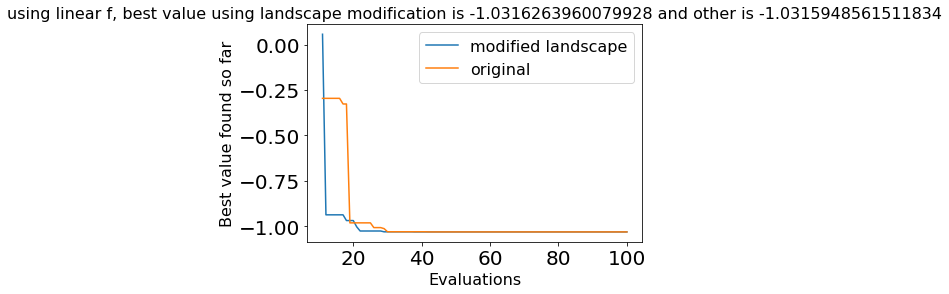

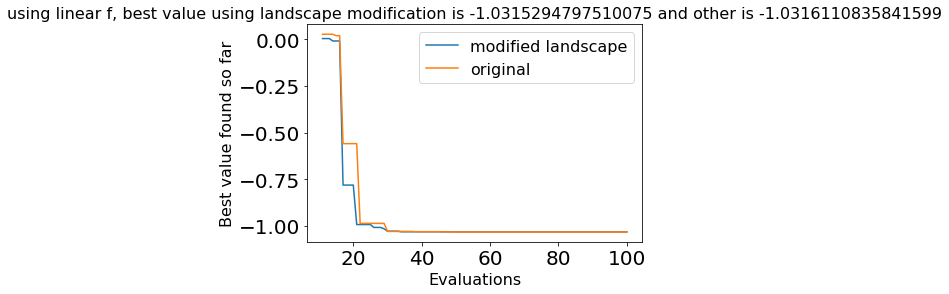

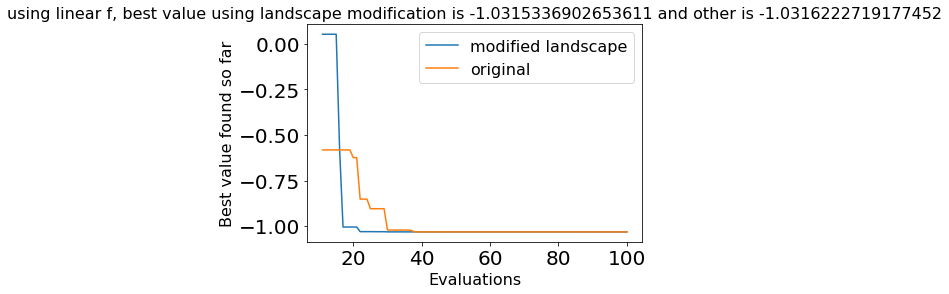

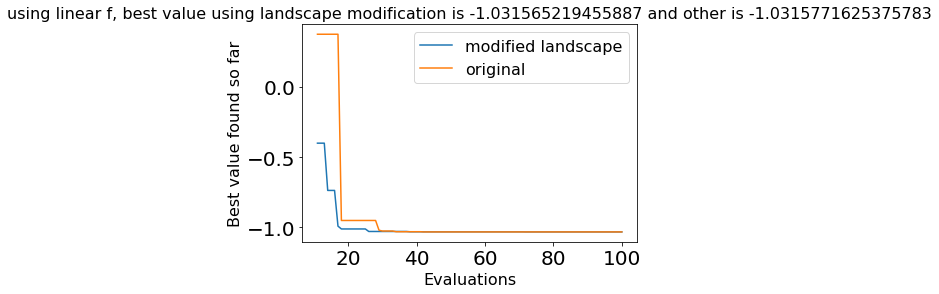

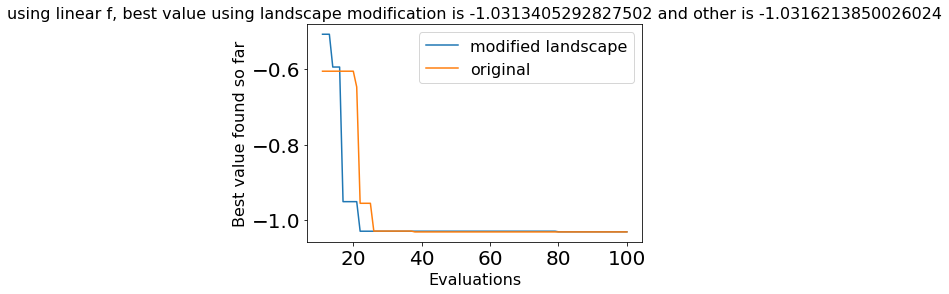

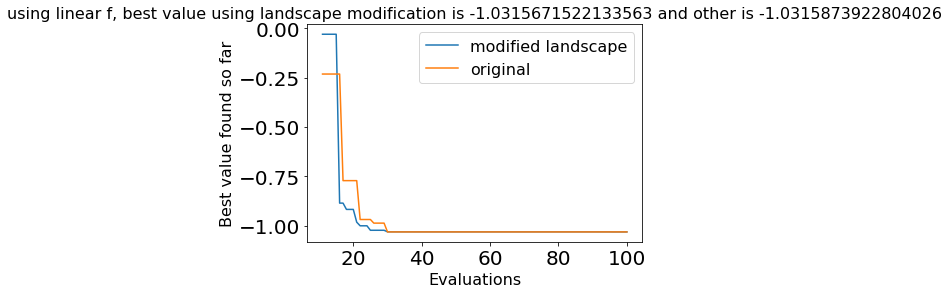

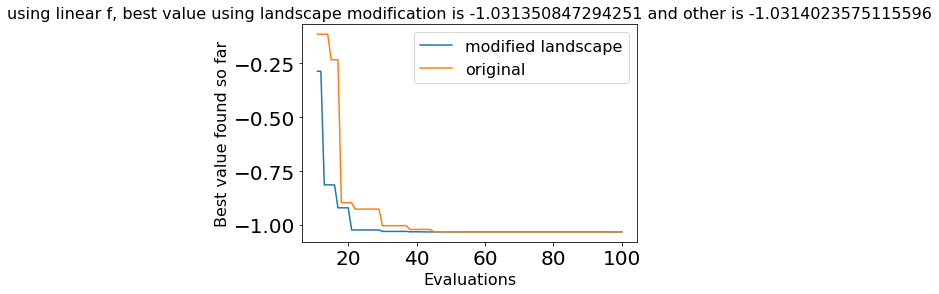

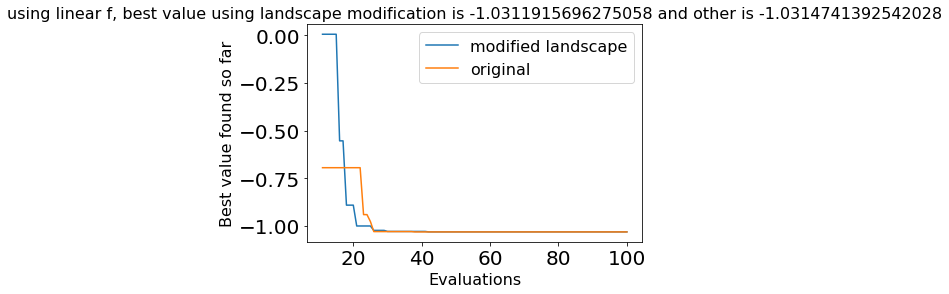

minimum was found


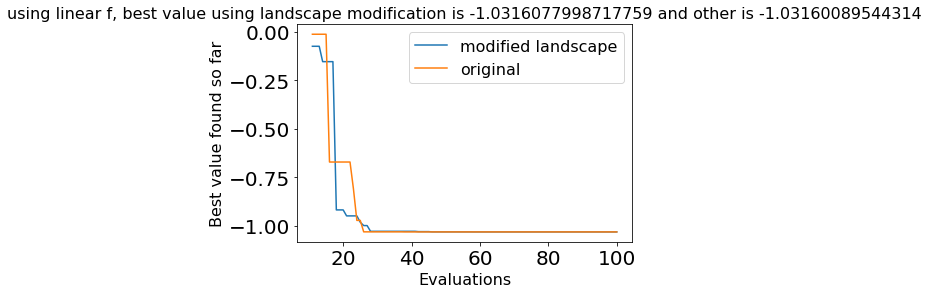

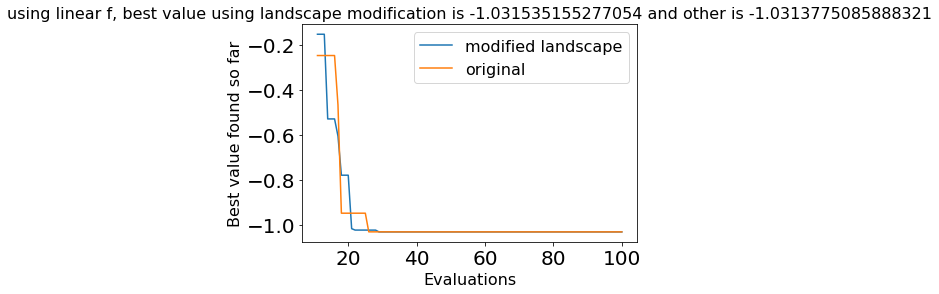

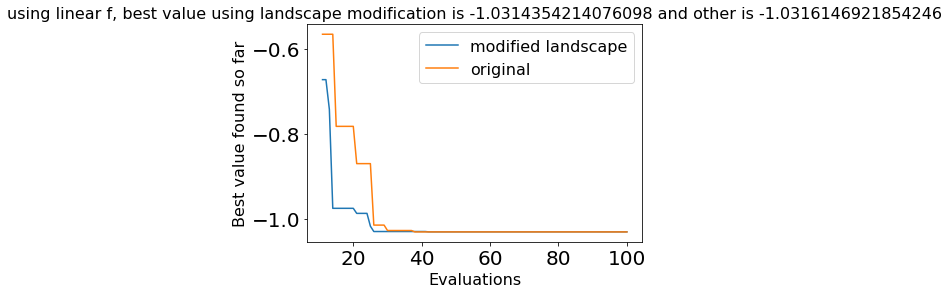

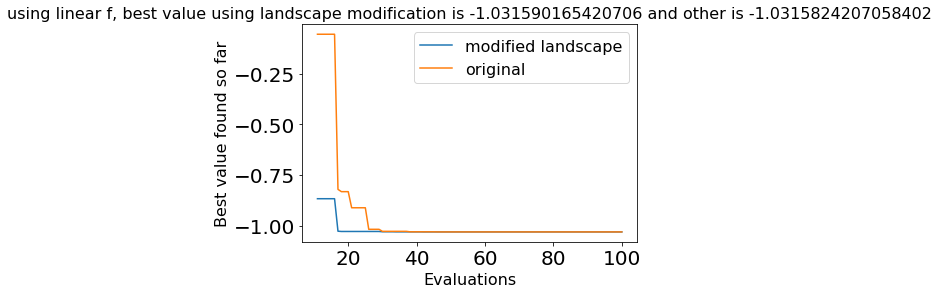

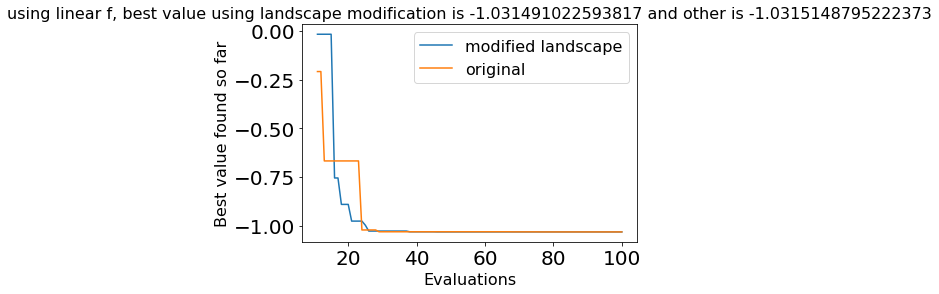

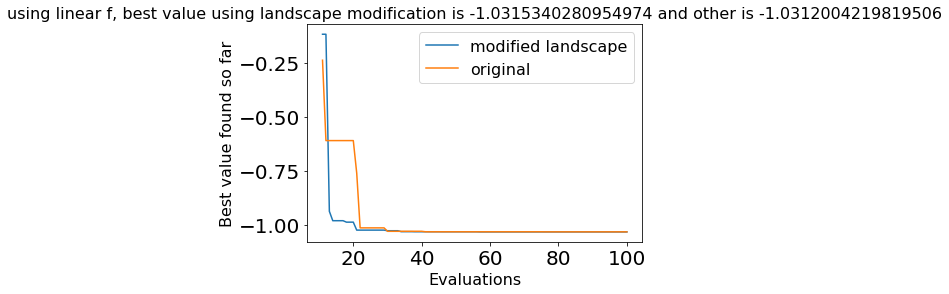

minimum was found


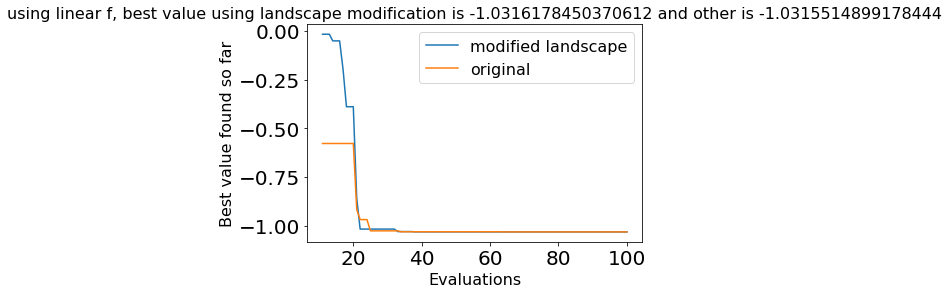

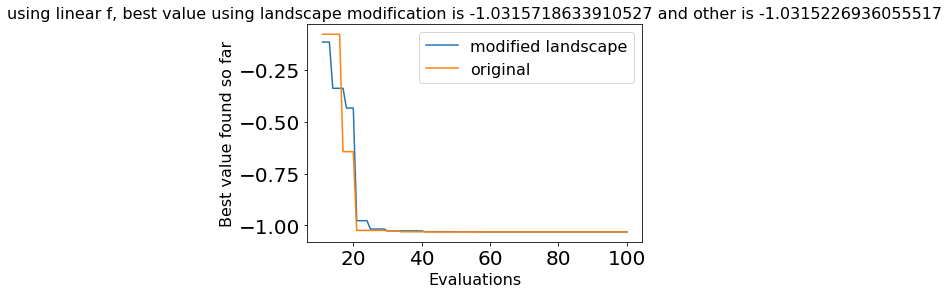

landscape modified was better 15 times and was worse 15 times
mean of landscape modified is -1.0315139021153585
mean of non landscape modified is -1.0315021188907334
median of landscape modified is -1.0315338591804293
median of non landscape modified is -1.0315427924701999
standard_deviation of landscape modified is 0.00010203362965849706
standard_deviation of non landscape modified is 0.00014208878451171106
best result of landscape modified is -1.0316263960079928
best of non landscape modified is -1.0316222719177452
worst result of landscape modified is -1.0311915696275058
worst of non landscape modified is -1.0309339349038888


([-1.0315111138796587,
  -1.0315121762809332,
  -1.0312681565218544,
  -1.0315095774036853,
  -1.0315128054073541,
  -1.0315988566863277,
  -1.0316191870842968,
  -1.0315291546815246,
  -1.0315534549725098,
  -1.0315939573028665,
  -1.0315410576449544,
  -1.0315307405007816,
  -1.0314590483111086,
  -1.03158959179021,
  -1.0316263960079928,
  -1.0315294797510075,
  -1.0315336902653611,
  -1.031565219455887,
  -1.0313405292827502,
  -1.0315671522133563,
  -1.031350847294251,
  -1.0311915696275058,
  -1.0316077998717759,
  -1.031535155277054,
  -1.0314354214076098,
  -1.031590165420706,
  -1.031491022593817,
  -1.0315340280954974,
  -1.0316178450370612,
  -1.0315718633910527],
 [-1.0315340950225553,
  -1.031431494123872,
  -1.0314529660571679,
  -1.0315568623600613,
  -1.03150753546411,
  -1.0315295830058278,
  -1.0315795881735856,
  -1.0314278928620262,
  -1.031513925779871,
  -1.0309339349038888,
  -1.0316180352227295,
  -1.0315682040031717,
  -1.0313571347779564,
  -1.0315966647749237

In [24]:
checker(30,path,l2)